<a href="https://colab.research.google.com/github/gavindoughtie/pytorch_class/blob/main/udemy_pytorch_08_PyTorchPaperReplicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. Milestone Project 2: PyTorch Paper Replicating

The goal of machine learning research paper replicating is: turn an ML research paper into usable code.

In this notebook, we're going to be replicating the [Vision Transformer (ViT) architecture paper](https://arxiv.org/abs/2010.11929) in PyTorch.

In [2]:
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.0+cu116
torchvision version: 0.14.0+cu116


In [11]:
# 0. Get setup
# import code we've already created and libraries.
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/data . # keep the data dir
    !mv pytorch-deep-learning/helper_functions.py .
    !rm -rf pytorch-deep-learning
    # Now that we've downloaded everything, import the modules we need:
    from going_modular.going_modular import data_setup, engine

In [7]:
# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
from helper_functions import plot_decision_boundary, plot_predictions, pred_and_plot_image, set_seeds
# Using my own download_data below, because it's nicer and re-uses the data from github

## 1. Get Data

Namely, the same mini pizza/steak/sushi data we've been using with CNNs.

In [9]:
%%writefile download_data.py
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination
    zipfile_path = (data_path / destination).with_suffix('.zip')

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        print(f'zipfile_path: {zipfile_path}')
        if not zipfile_path.is_file():
          with open(zipfile_path, "wb") as f:
              request = requests.get(source)
              print("Downloading data...")
              f.write(request.content)

    # Unzip pizza, steak, sushi data
    if zipfile_path.is_file():
      with zipfile.ZipFile(zipfile_path, "r") as zip_ref:
          print("Unzipping data...") 
          zip_ref.extractall(image_path)

      # Remove .zip file
      if remove_source:
          os.remove(zipfile_path)
    
    return image_path

Writing download_data.py


In [10]:
from download_data import download_data
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi",
                           remove_source=False)
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.
Unzipping data...
[INFO] data/pizza_steak_sushi directory exists, skipping download.
Unzipping data...


PosixPath('data/pizza_steak_sushi')

## 2. Create Datasets and Dataloaders

In [14]:
BATCH_SIZE=32
IMG_SIZE=224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [19]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, len(train_dataloader), test_dataloader, len(test_dataloader), class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fac878c18e0>,
 8,
 3,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

As always... visualize! Visualize! VISUALIZE!

In [45]:
# Get a batch of images
image_batch, label_batch = next(iter(test_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

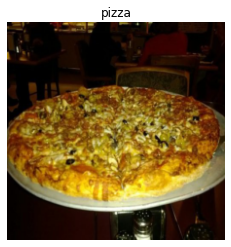

In [46]:
# Plot the demo image
import matplotlib.pyplot as plt
plt.imshow(image.squeeze().permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)